In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(Array([2, 1], dtype=int32),
 Array([[1, 2]], dtype=int32),
 Array([0, 0], dtype=int32))

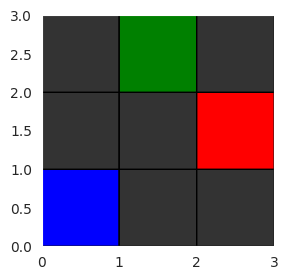

In [63]:
from types import SimpleNamespace
import os
os.environ['CUDA'] = '/usr/local/cuda-12'
os.environ['PATH'] = '/usr/local/cuda-12/bin${PATH:+:${PATH}}'

import jax as jx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import json
import environments
import math
from simple_model_networks import *

with open('configs/EW_simple_model.json', 'r') as f:
    config = json.load(f)

def render(state):
    goal, enemy_coords, pos = state
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros((env.grid_size, env.grid_size))
    arr[goal[0], goal[1]] = 2
    arr[pos[0], pos[1]] = 3
    for enemy_coord in enemy_coords:
        arr[enemy_coord[0], enemy_coord[1]] = 1
    plt.figure(figsize=(3,3))
    plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)


def set_default(d, k, v):
    if k not in d:
        d[k] = v

set_default(config, "double_DQN", False)
set_default(config, "episodic_env", False)
set_default(config, "updates_per_step", 1)
set_default(config, "save_final_params", True)
config = SimpleNamespace(**config)

Environment = getattr(environments, config.environment)

env_config = config.env_config

key = jx.random.PRNGKey(600)
seed_id = 2
env = Environment(**env_config)
num_actions = env.num_actions()
state, obs = env.reset(key)
render(state)
state

In [20]:
import pickle as pkl
with open('out/ENEMY_WALK.params', 'rb') as f:
    data = pkl.load(f)
len(data['Q'])

30

In [21]:
Q_net = hk.without_apply_rng(hk.transform(lambda obs: Q_function(config, env.num_actions())(obs)))
key, subkey = jx.random.split(key)
subkeys = jx.random.split(subkey, num=config.num_seeds)
Q_params = [Q_net.init(subkey, obs.astype(float)) for subkey in subkeys]
Q_func = Q_net.apply


(Array([-0.4276199 , -0.46099913, -0.52448094, -0.20282978, -0.5547378 ],      dtype=float32),
 Array([0.19969872, 0.19314294, 0.18126296, 0.25003475, 0.17586064],      dtype=float32))

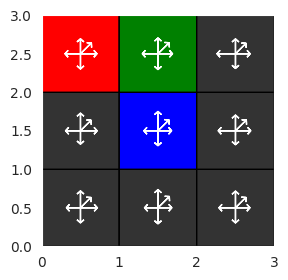

In [30]:
def render_q(stat):
    render(stat)
    scale = 1
    goal, enemy_coords, player = stat
    move_map = env.move_map.astype(float)
    move_map = move_map.at[0].set([1/math.sqrt(2), 1/math.sqrt(2)]) # plot inaction as diagonal
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            player = jnp.array((i, j))
            ob = env.get_observation((goal, enemy_coords, player))
            qs = Q_func(data['Q'][seed_id], ob)
            qs = jx.nn.softmax(qs)

            for a, q in enumerate(qs):
                arr_dir = move_map[a]
                plt.arrow(player[1] + 0.5, player[0] + 0.5, scale*arr_dir[1]*q, scale*arr_dir[0]*q, head_width=0.09, head_length=0.04, length_includes_head=True, color='white', overhang=1)

render_q(state)
q_ex = Q_func(data['Q'][seed_id], obs)
q_ex, jx.nn.softmax(q_ex)

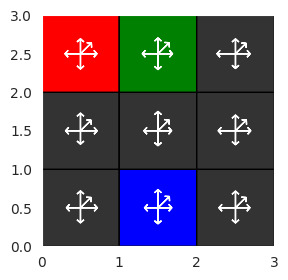

In [31]:
key, subkey = jx.random.split(key)
new_state, new_obs, rew, terminal, info = env.step(subkey, state, 1)
render_q(new_state)

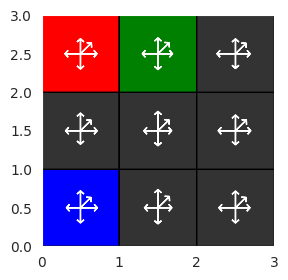

In [32]:
new_state2, new_obs2, rew2, terminal2, info2 = env.step(key, new_state, 2)
render_q(new_state2)

In [33]:
import pickle as pkl
with open('out/EW_simple_model.params', 'rb') as f:
    data = pkl.load(f)
len(data['model'])

30

In [34]:
data['model'][seed_id]['next_obs']

{'next_obs_function/linear': {'b': Array([ 2.64100373e-01, -8.72174799e-02,  6.25447333e-02, -5.34439087e-02,
         -1.84358936e-02, -5.92243625e-03, -3.93549651e-02,  2.32999235e-01,
          8.95935744e-02, -3.48756909e-01, -1.93751603e-01, -4.21668664e-02,
          2.79281288e-01, -8.53872821e-02, -3.16004455e-01,  4.38137315e-02,
          1.26964912e-01,  3.17475051e-02, -1.46277428e-01, -2.50095695e-01,
         -1.11549124e-01,  1.55198485e-01, -7.65244337e-03,  2.44660690e-01,
          8.11741650e-02, -2.91573722e-02,  2.94907321e-03,  1.92791507e-01,
         -6.61163330e-02,  1.99434921e-01,  8.20991173e-02,  1.95841327e-01,
         -6.28090054e-02,  1.38228223e-01, -2.75930110e-03, -2.31479798e-02,
          1.03289165e-01,  1.23967499e-01, -1.82151198e-01,  3.54111157e-02,
         -2.51455575e-01, -5.34757897e-02,  7.06553608e-02,  7.84709901e-02,
          1.20590374e-01, -2.49585226e-01, -1.92271188e-01,  1.39057577e-01,
         -1.38766646e-01, -1.19478442e-01, 

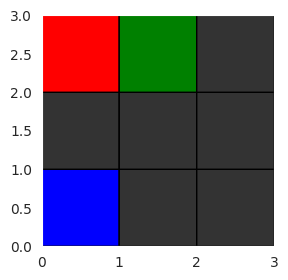

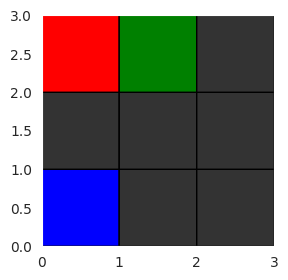

In [40]:
def render_obs(obs):
    grid_shape = (env.grid_size, env.grid_size)
    obs2 = np.reshape(np.array(obs, dtype=int), (*grid_shape, 4))
    player, goal, enemy = obs2[:,:,0], obs2[:,:,1], obs2[:,:,2]
    cmap = colors.ListedColormap(['#333333','red', 'green', 'blue'])
    arr = np.zeros(grid_shape)
    arr += enemy
    arr = np.maximum(arr, goal * 2)
    arr = np.maximum(arr, player * 3)
    plt.figure(figsize=(3,3))
    plt.pcolor(arr, cmap=cmap, edgecolors='k', linewidths=1, vmin=0, vmax=3)

render(new_state2)
render_obs(new_obs2)

In [41]:
dummy_a = jnp.zeros((env.num_actions()))

reward_net = hk.without_apply_rng(hk.transform(lambda obs, a: reward_function(config)(obs, a)))
key, subkey = jx.random.split(key)
subkeys = jx.random.split(subkey, num=config.num_seeds)
reward_params = data['model'][seed_id]['reward']
reward_func = reward_net.apply

termination_net = hk.without_apply_rng(hk.transform(lambda obs, a: termination_function(config)(obs, a)))
key, subkey = jx.random.split(key)
subkeys = jx.random.split(subkey, num=config.num_seeds)
termination_params = data['model'][seed_id]['termination']
termination_func = termination_net.apply

next_obs_net = hk.without_apply_rng(
    hk.transform(lambda obs, a, key: next_obs_function(config, obs.shape[0])(obs, a, key)))
key, subkey = jx.random.split(key)
subkeys = jx.random.split(subkey, num=config.num_seeds)
next_obs_params = data['model'][seed_id]['next_obs']
next_obs_func = next_obs_net.apply

model_funcs = {"reward": reward_func, "termination": termination_func, "next_obs": next_obs_func}

model_params = [{"reward": rp, "termination": tp, "next_obs": no} for rp, tp, no in
                zip(reward_params, termination_params, next_obs_params)]

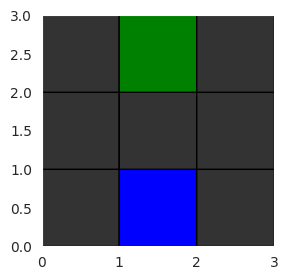

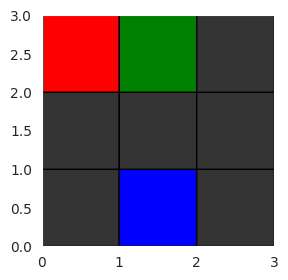

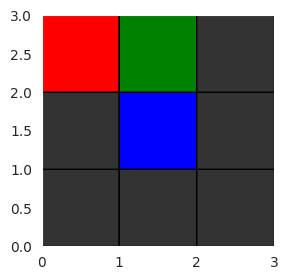

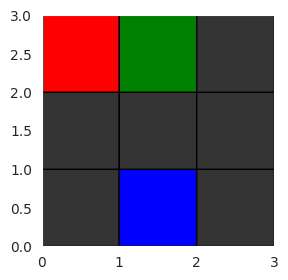

In [57]:
next_obs, logits = next_obs_func(next_obs_params, obs, jnp.eye(num_actions)[1], key)
render_obs(next_obs)
render_obs(logits['logit'] > 0)
render_obs(obs)
render_obs(new_obs)

In [56]:
np.reshape(np.array(logits['logit']), (env.grid_size, env.grid_size, 4))[:,:,0] > 0

array([[False, False, False],
       [False, False, False],
       [False,  True, False]])

In [ ]:
from vq_vae import *

def get_model_network(config, obs_width):
    encoder = Encoder(config)
    decoder = Decoder(config, obs_width)
    vq = VectorQuantizerEMA(config.latent_dim, config.num_embeddings, config.commitment_cost, decay=config.embedding_decay)
    def model_network(model_params, curr_obs, action, reward, next_obs, terminal, metrics, key):

        embedding = encoder(curr_obs, action, next_obs)
        quantization = vq(embedding)
        decoded = decoder(curr_obs, action, quantization['quantize'])

        return next_obs_sample, o_hat_dist, r_dist, gamma_dist, embedding_loss, metrics
    return model_network


